# Example pipeline: WMAP model

In this tutorial, we will illustrate a more realistic use of IMAGINE: to show how to constrain a few parameters of the WMAP GMF model. 

We will first prepare a mock dataset, using Hammurabi itself for this. Then, assemble the pipeline and execute it.

First, let us import the necessary packages.

In [1]:
# Builtin 
import os
# External packages 
import numpy as np
import healpy as hp
import astropy.units as u
import corner
import matplotlib.pyplot as plt
import cmasher as cmr
# IMAGINE
import imagine as img
import imagine.observables as img_obs
## WMAP field factories
from imagine.fields.hamx import BregLSA, BregLSAFactory
from imagine.fields.hamx import TEregYMW16, TEregYMW16Factory
from imagine.fields.hamx import CREAna, CREAnaFactory

## Logging

IMAGINE comes with logging features using Python's native [logging package](https://docs.python.org/3/library/logging.html). To enable them, one can simply set where one wants the log file to be saved and what is the level of the logging.

In [2]:
import logging

logging.basicConfig(filename='tutorial_five.log',
                    level=logging.INFO)

Under `logging.INFO` level, IMAGINE will report major steps and log the likelihood evaluations. If one wants to trace a specific problem, one can use the `logging.DEBUG` level, which reports when most of the functions or methods are accessed.

## Preparing the mock data

Let's make a very low resolution map of synchrotron total I and Faraday depth from the WMAP model, including a random compnent:

In [3]:
## Sets the resolution
nside=2
size = 12*nside**2 

# Generates the fake datasets 
sync_dset = img_obs.SynchrotronHEALPixDataset(data=np.empty(size)*u.K, 
                                              frequency=23, typ='I')
fd_dset = img_obs.FaradayDepthHEALPixDataset(data=np.empty(size)*u.rad/u.m**2)

# Appends them to an Observables Dictionary
trigger = img_obs.Measurements()
trigger.append(dataset=sync_dset)
trigger.append(dataset=fd_dset)

# Prepares the Hammurabi simmulator for the mock generation
mock_generator = img.simulators.Hammurabi(measurements=trigger)

observable {}
|-->  sync {'cue': '1', 'freq': '23', 'nside': '2'}
|-->  faraday {'cue': '1', 'nside': '2'}


We will feed the `mock_generator` simulator with selected Dummy fields.

In [4]:
# BregLSA field
breg_lsa = BregLSA(parameters={'b0':3, 'psi0': 27.0, 'psi1': 0.9, 'chi0': 25.0})

# CREAna field
cre_ana = CREAna(parameters={'alpha': 3.0, 'beta': 0.0, 'theta': 0.0,
                             'r0': 5.0, 'z0': 1.0,
                             'E0': 20.6, 'j0': 0.0217})

# TEregYMW16 field
tereg_ymw16 = TEregYMW16(parameters={})

In [5]:
## Generate mock data (run hammurabi)
outputs = mock_generator([breg_lsa, cre_ana, tereg_ymw16])

To make a realistic mock, we add to these outputs, which where constructed from a model with known parameter, some noise, which assumed to be proportional to the average synchrotron intensity.

/home/lrodrigues/miniconda3/envs/imagine/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("cmr.rainforest"))
  newcm.set_over(newcm(1.0))
/home/lrodrigues/miniconda3/envs/imagine/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("cmr.rainforest"))
  newcm.set_under(bgcolor)
/home/lrodrigues/miniconda3/envs/imagine/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally reg

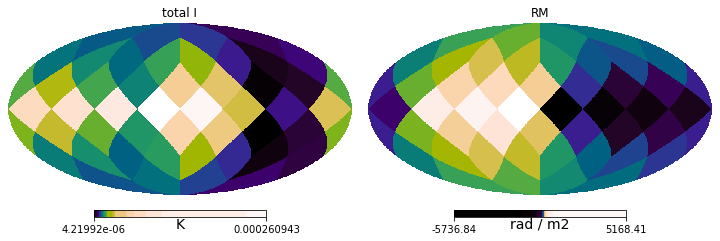

In [6]:
## Collect the outputs
mockedI = outputs[('sync', 23.0, nside, 'I')].global_data[0]
mockedRM = outputs[('fd', None, nside, None)].global_data[0]
dm=np.mean(mockedI)
dv=np.std(mockedI)

## Add some noise that's just proportional to the average sync I by the factor err
err=0.01
dataI = (mockedI + np.random.normal(loc=0, scale=err*dm, size=size)) << u.K
errorI = ((err*dm)**2) << u.K
sync_dset = img_obs.SynchrotronHEALPixDataset(data=dataI, error=errorI,
                                              frequency=23, typ='I')

## Just 0.01*50 rad/m^2 of error for noise.  
dataRM = (mockedRM + np.random.normal(loc=0.,scale=err*50.,size=12*nside**2))*u.rad/u.m/u.m
errorRM = ((err*50.)**2) << u.rad/u.m**2
fd_dset = img_obs.FaradayDepthHEALPixDataset(data=dataRM, error=errorRM)


fig = plt.figure(figsize=(10.0, 4.0))
hp.mollview(dataI, norm='hist', cmap='cmr.rainforest',sub=(1,2,1),title="total I",unit=dataI.unit, fig=fig)
hp.mollview(dataRM, norm='hist', cmap='cmr.rainforest',sub=(1,2,2),title="RM",unit=dataRM.unit,fig=fig)

We are ready to include the above data in `Measurements` and  objects

In [7]:
mock_data = img_obs.Measurements()
mock_data.append(dataset=sync_dset)
mock_data.append(dataset=fd_dset)

mock_cov = img_obs.Covariances()
mock_cov.append(dataset=sync_dset)
mock_cov.append(dataset=fd_dset)

## Assembling the pipeline

After preparing our mock data, we can proceed with the set up of the IMAGINE pipeline. First, we initialize the `Likelihood`, using the mock observational data

In [8]:
## Use an ensemble to estimate the galactic variance
likelihood = img.likelihoods.EnsembleLikelihood(mock_data, mock_cov)

Then, we prepare the `FieldFactory` list:

In [9]:
## WMAP B-field, vary only b0 and psi0
breg_factory = BregLSAFactory()
breg_factory.active_parameters = ('b0', 'psi0')
breg_factory.priors = {'b0':  img.priors.FlatPrior(xmin=0., xmax=10.), 
                      'psi0': img.priors.FlatPrior(xmin=0., xmax=50.)}
## Fixed CR model
cre_factory = CREAnaFactory()
## Fixed FE model
fereg_factory = TEregYMW16Factory()

# Final Field factory list
factory_list = [breg_factory, cre_factory, fereg_factory]

We initialize the `Simulator`, in this case: `Hammurabi` .

In [10]:
simulator = img.simulators.Hammurabi(measurements=mock_data)

observable {}
|-->  sync {'cue': '1', 'freq': '23', 'nside': '2'}
|-->  faraday {'cue': '1', 'nside': '2'}


Finally, we initialize and setup the `Pipeline` itself, using the `Multinest` sampler.

In [11]:
# Creates a directory for MultiNest's chains
chains_dir = 'tutorial_five_pipeline_example_chains'
os.makedirs(chains_dir, exist_ok=True)

# Assembles the pipeline using MultiNest as sampler
pipeline = img.pipelines.MultinestPipeline(simulator=simulator, 
                                           show_progress_reports=True,
                                           factory_list=factory_list, 
                                           likelihood=likelihood, 
                                           ensemble_size=1, n_evals_report=15,
                                           chains_directory=chains_dir)
pipeline.sampling_controllers = {'n_live_points': 500, 'resume': True}

We created a directory `'pipeline_example_chains_dir'` for storing MultiNest's the chains during this IMAGINE run. This is *strongly recommended*, as it makes it easier to resume a crashed or interrupted IMAGINE run, but if the argument `chains_directory` is absent, a temporary directory is created instead (and is deleted after completion).

Since there are no stochastic fields in this model, we chose an ensemble size of 1. We also instructed MultiNest to try to resume a previous run based on the any data left in the chains directory.

## Checking

Before running a heavy job, it is a good idea to be able to roughly estimate how long it will take (so that one can e.g. decide whether one will read emails, prepare some coffee, or take a week of holidays while waiting for the results).

One thing that can be done is checking how long the code takes to do an individual likelihood function evaluation (note that each of these include the whole ensemble).  The final likelihood function handled to the sampler can be accessed through the internal method `_likelihood_function`, which takes an array of parameter values. Below we time a randomly picked point (the timing was done on a regular, 8 core, personal computer).

In [12]:
%time pipeline._likelihood_function([5,25])

CPU times: user 15.9 ms, sys: 24 ms, total: 39.9 ms
Wall time: 3.7 s


-63216507.9863329

This is not a small amount of time.  Note that thousands of evaluations will be needed to be able to estimate the evidence (and/or posterior distributions). 
Fortunately, this tutorial comes with the results from an interrupted run, reducing the amount of waiting in case someone is interested in seeing the pipeline in action.

## Running on a jupyter notebook

While running the pipeline in a jupyter notebook, a simple progress report is generated every `pipeline.n_evals_report` evaluations of the likelihood. In the nested sampling case, this shows the parameter choices for rejected ("dead") points  as a function of log "prior volume", $\ln X$, and the distributions of both rejected points and "live" points (the latter in red).


**Progress report:**
number of likelihood evaluations  30

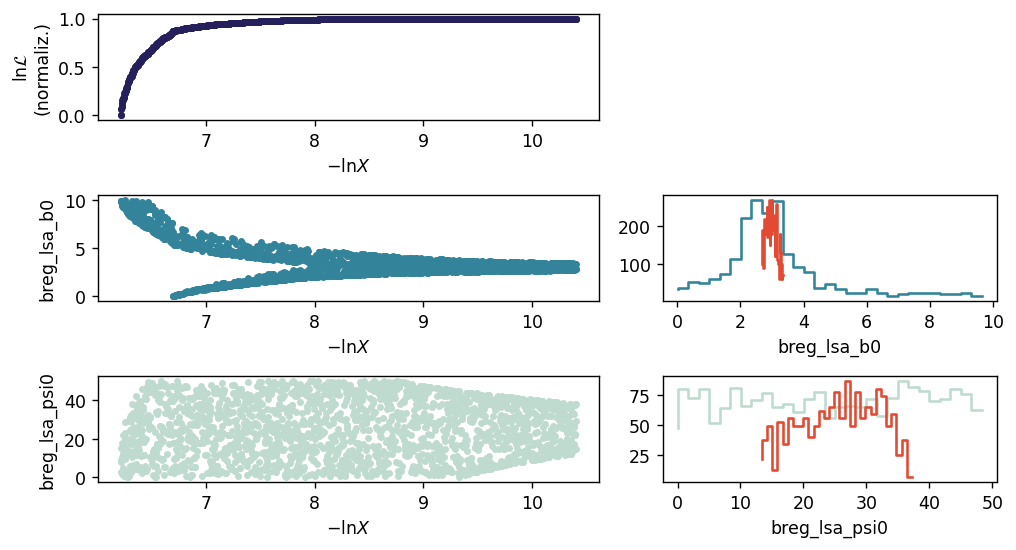

In [ ]:
results=pipeline()

## Monitoring progress when running as script

When IMAGINE is launched using a script (e.g. when running on a cluster) it is still possible to monitor the progress by inspecting the file `progress_report.pdf` in the selected chains directory. 